In [0]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from numpy import asarray
from pathlib import Path
import cv2
import numpy as np
from google.colab import drive
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from numpy import load
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from matplotlib import pyplot
from sklearn.metrics import classification_report

In [13]:
drive.mount('/content/drive')
source = '/content/drive/My Drive/CMPE256/src'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def getListOfImages(source):
     return list(Path(source).glob('**/*.png'))    

def readImages(images,img_width,img_height):
    X=[]
    Y=[]
    for imagePath in images:
        imagePath = str(imagePath)
        imgArr = cv2.imread(imagePath)
        imgArr = cv2.resize(imgArr, (img_width, img_height)) 
        #imgArr = imgArr.reshape((1,) + imgArr.shape)
        X.append(imgArr)
        Y.append(int(imagePath.split("/")[-1].split("-")[0][3:]) - 1)
    X = asarray(X)
    Y = asarray(Y)
    return (X,Y)

In [0]:
num_classes = 62
img_width = 64
img_height = 64
channels = 3

In [0]:
#Takes a lot of time on google colab hence save the data into npz format and directly load it
#images = getListOfImages(source+'/Data')
#%time X,y = readImages(images,img_width,img_height)
#y = to_categorical(y)

In [17]:
X = load(source+'/Data/images.npz')
y = load(source+'/Data/labels.npz')
X = X['arr_0']
y = y['arr_0']
num_samples = len(X)
print(X.shape,y.shape)

(74107, 64, 64, 3) (74107, 62)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
print("Training set size : ",len(X_train))
print("Testing set  size : ",len(y_train))

Training set size :  59285
Testing set  size :  59285


In [20]:
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, channels), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
epochs = 10
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)              

In [0]:
# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [22]:
# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32,callbacks=callbacks_list)

Train on 59285 samples, validate on 14822 samples
Epoch 1/10
59285/59285 [==============================] - 22s 372us/step - loss: 2141.0919 - accuracy: 0.0216 - val_loss: 4.1242 - val_accuracy: 0.0208
Epoch 2/10
59285/59285 [==============================] - 22s 369us/step - loss: 4.1229 - accuracy: 0.0222 - val_loss: 4.1244 - val_accuracy: 0.0208
Epoch 3/10
59285/59285 [==============================] - 22s 369us/step - loss: 4.1226 - accuracy: 0.0223 - val_loss: 4.1245 - val_accuracy: 0.0208
Epoch 4/10
59285/59285 [==============================] - 22s 369us/step - loss: 4.1225 - accuracy: 0.0223 - val_loss: 4.1245 - val_accuracy: 0.0208
Epoch 5/10
59285/59285 [==============================] - 22s 369us/step - loss: 4.1225 - accuracy: 0.0223 - val_loss: 4.1245 - val_accuracy: 0.0208
Epoch 6/10
59285/59285 [==============================] - 22s 369us/step - loss: 4.1224 - accuracy: 0.0223 - val_loss: 4.1245 - val_accuracy: 0.0208
Epoch 7/10
59285/59285 [=============================

In [23]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 2.08%


Visual Analysis


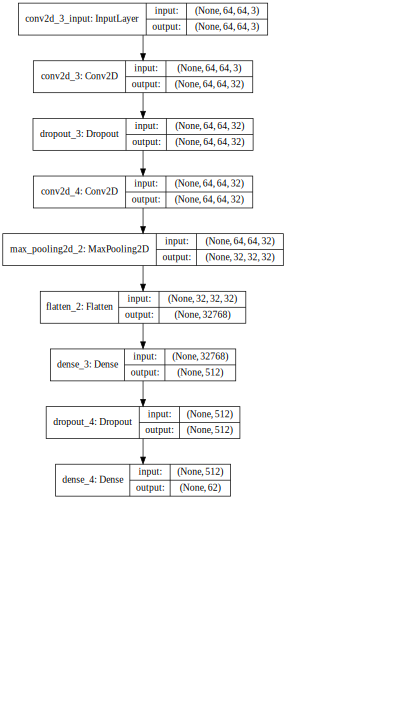

In [75]:
from IPython.display import SVG
from keras.utils import model_to_dot
#model
SVG(model_to_dot(model,show_shapes=True,expand_nested=True,dpi=50).create(prog='dot', format='svg'))

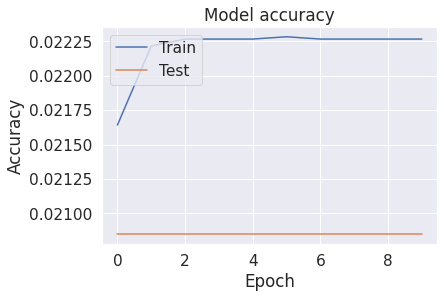

In [65]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

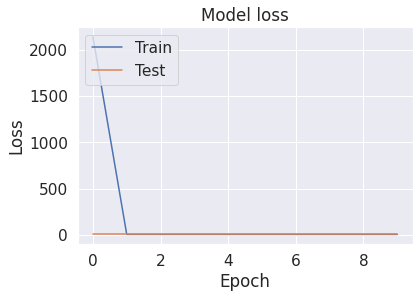

In [66]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
def createConfusionMatrix(trueLabel,PredictedLabel):
    return confusion_matrix(trueLabel,PredictedLabel,normalize="true")

In [0]:
def plotConfusionMatrix(matrix):
  df_cm = pd.DataFrame(matrix,range(matrix.shape[0]),range(matrix.shape[1]))
  plt.figure(figsize = (20,20))
  sn.set(font_scale=1.2)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}) 

In [0]:
#Get the predicted classes for all the samples in testing set
y_pred = model.predict_classes(X_test)

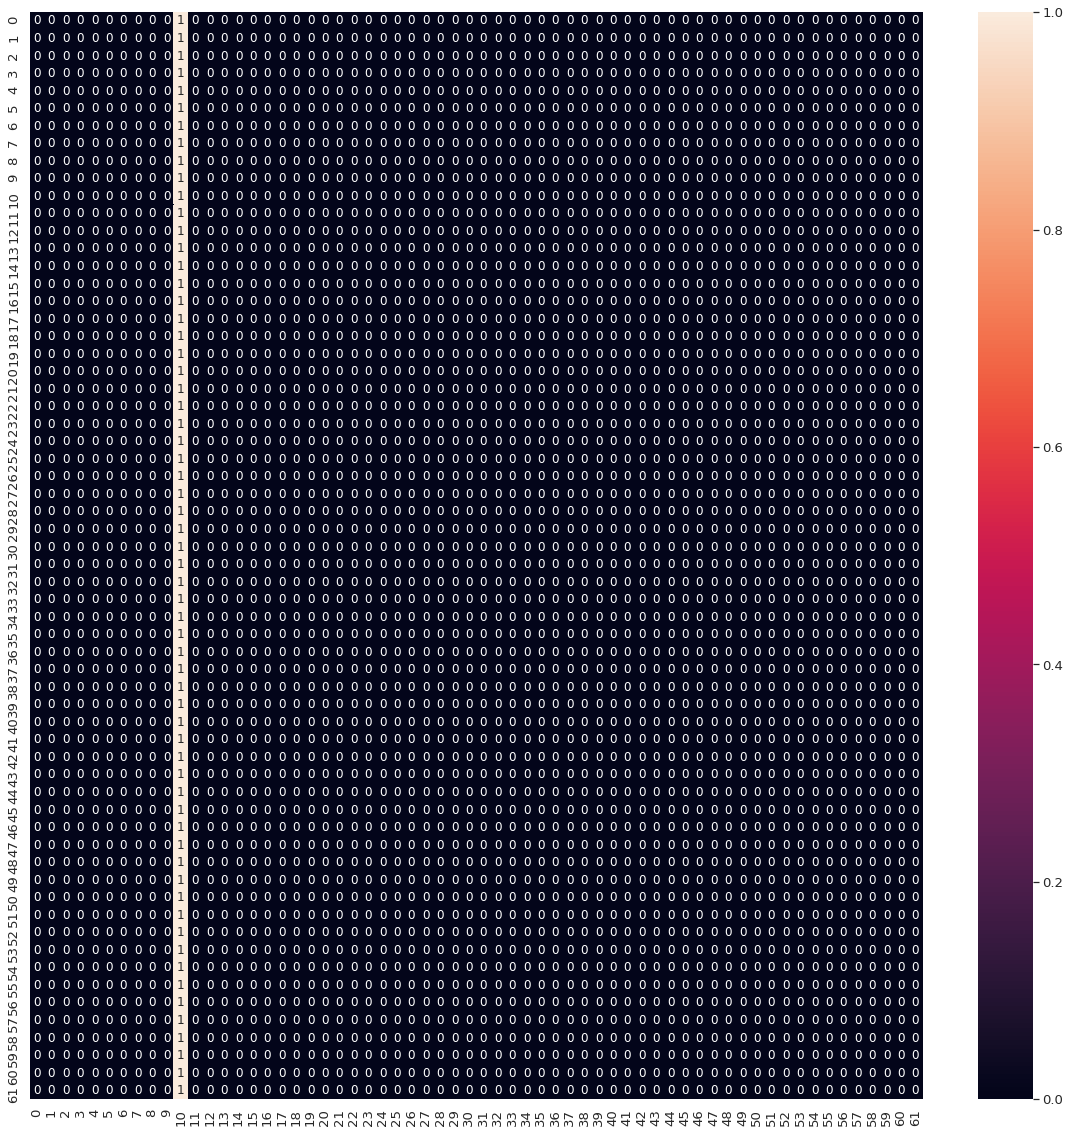

In [70]:
#Create and plot the confusion matrix
cm = createConfusionMatrix(y_test.argmax(axis=1),y_pred)
plotConfusionMatrix(cm)

In [81]:
print(classification_report(y_test.argmax(axis=1),y_pred,zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.00      0.00      0.00       222
           2       0.00      0.00      0.00       236
           3       0.00      0.00      0.00       217
           4       0.00      0.00      0.00       228
           5       0.00      0.00      0.00       232
           6       0.00      0.00      0.00       223
           7       0.00      0.00      0.00       212
           8       0.00      0.00      0.00       227
           9       0.00      0.00      0.00       233
          10       0.02      1.00      0.04       309
          11       0.00      0.00      0.00       218
          12       0.00      0.00      0.00       273
          13       0.00      0.00      0.00       257
          14       0.00      0.00      0.00       297
          15       0.00      0.00      0.00       227
          16       0.00      0.00      0.00       236
          17       0.00    